# Лабораторна робота №7

### Студента групи МІТ-31 (підгрупа 1)

### Добровольського Арсенія Михайловича

#### Мета:
Розробка та порівняння моделей глибокого навчання для мультикласової класифікації трьох класів зображень їжі, а також використання transfer learning для покращення результатів.

#### Дані:
Набір даних: [10_food_classes_all_data.zip](https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip).

#### Завдання:
1. **Вибір Класів:**
   - Виберіть три класи з набору даних для класифікації на основі методики вибору з практичної роботи.

2. **Попередня Обробка:**
   - Завантажте та розпакуйте набір даних.
   - Поділіть дані на тренувальний, валідаційний та тестовий набори.
   - Виконайте необхідну попередню обробку даних.

3. **Розробка та Тренування Моделей:**
   - Створіть три різні моделі глибокого навчання для класифікації обраних класів. Наприклад, ви можете змінювати архітектуру, кількість шарів, активаційні функції тощо.
   - Тренуйте кожну модель на тренувальному наборі даних та валідуйте їх на валідаційному наборі.

4. **Оцінка Моделей:**
   - Оцініть кожну модель на тестовому наборі даних.
   - Запишіть та порівняйте результати точності та часу тренування для кожної моделі.

5. **Додаткове Завдання (на високу оцінку):**
   - Використайте transfer learning з використанням EfficientNet з TensorFlow Hub для класифікації тих самих трьох класів.
   - Порівняйте результати цієї моделі з попередніми трьома за точністю та часом тренування.


### Necessary imports

In [1]:
import os
import time
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import tensorflow_hub as hub
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPool2D

### Dataset displaying

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data\test'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\steak'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\sushi'.
There are 

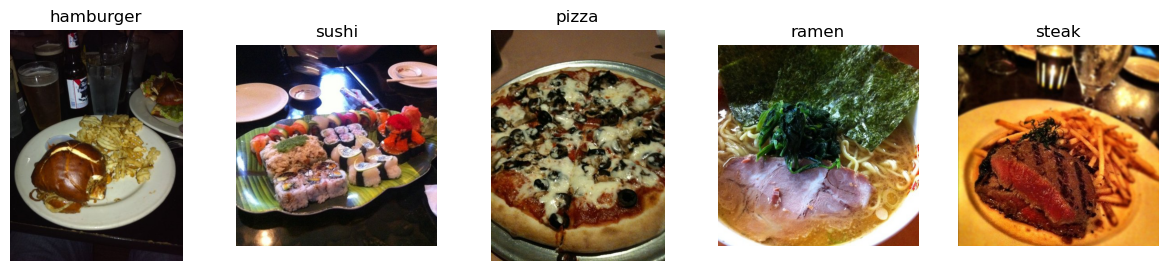

In [2]:
main_dir="10_food_classes_all_data"

for dirpath, dirnames, filenames in os.walk(main_dir):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

def view_random_images(target_dir, num_images):
    # Get random classes
    random_classes = random.sample(os.listdir(target_dir), num_images)

    # Plot images in a single row without axes
    plt.figure(figsize=(15, 3))
    for i, target_class in enumerate(random_classes, 1):
        target_folder = os.path.join(target_dir, target_class)
        # One random image from each class
        random_image = random.choice(os.listdir(target_folder))
        img_path = os.path.join(target_folder, random_image)
        img = mpimg.imread(img_path)
        
        plt.subplot(1, num_images, i)
        plt.imshow(img)
        plt.title(target_class)
        plt.axis("off")

        print(f"Image {i} shape: {img.shape}")  # show the shape of each image

    plt.show()

# View 5 random images from random classes
view_random_images(target_dir="10_food_classes_all_data/train/", num_images=5)


### Data processing

In [3]:
tf.random.set_seed(42)

# Setup the train and test directories
train_dir = main_dir+"/train/"
test_dir = main_dir+"/test/"

classes = ['steak', 'ramen', 'pizza']

# Preprocess data (normalization)
train_datagen = ImageDataGenerator(rescale=1/255.,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   validation_split=0.2, # 20% of the training data will be used for validation
                                   horizontal_flip=True,
                                   fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1/255.)

batch_size = 32

train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               batch_size=batch_size,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=classes,
                                               shuffle=True,
                                               seed=42,
                                               subset='training')

val_data = train_datagen.flow_from_directory(directory=train_dir,
                                             batch_size=batch_size,
                                             target_size=(224, 224),
                                             class_mode='categorical',
                                             classes=classes,
                                             shuffle=False,
                                             seed=42,
                                             subset='validation')

test_data = test_datagen.flow_from_directory(directory=test_dir,
                                             batch_size=batch_size,
                                             target_size=(224, 224),
                                             class_mode='categorical',
                                             classes=classes,
                                             shuffle=False,
                                             seed=42)

Found 1800 images belonging to 3 classes.
Found 450 images belonging to 3 classes.
Found 750 images belonging to 3 classes.


### Models

In [4]:
def train_time_and_efficiency(model, train_data, epochs, val_data=None, test_data=None, lr_scheduler = None):
    start_time = time.time()

    history = model.fit(train_data,
                        epochs=epochs,
                        steps_per_epoch=len(train_data),
                        validation_data=val_data,
                        validation_steps=len(val_data) if val_data else None,
                        callbacks=[lr_scheduler] if lr_scheduler else None)

    end_time = time.time()
    training_time = end_time - start_time

    print(f"Training Time: {training_time:.2f} seconds")
    
    if test_data:
        test_loss, test_accuracy = model.evaluate(test_data, steps=len(test_data))
        print(f'Test Loss: {test_loss}')
        print(f'Test Accuracy: {test_accuracy}')

    return history


Epoch 1/10
57/57 [==============================] - 145s 2s/step - loss: 1.1777 - accuracy: 0.4033 - val_loss: 1.0226 - val_accuracy: 0.5133
Epoch 2/10
57/57 [==============================] - 116s 2s/step - loss: 0.9529 - accuracy: 0.5533 - val_loss: 0.9753 - val_accuracy: 0.4978
Epoch 3/10
57/57 [==============================] - 114s 2s/step - loss: 0.9026 - accuracy: 0.5917 - val_loss: 0.8773 - val_accuracy: 0.6356
Epoch 4/10
57/57 [==============================] - 123s 2s/step - loss: 0.8572 - accuracy: 0.6178 - val_loss: 0.8715 - val_accuracy: 0.5889
Epoch 5/10
57/57 [==============================] - 115s 2s/step - loss: 0.8468 - accuracy: 0.6289 - val_loss: 0.9113 - val_accuracy: 0.6044
Epoch 6/10
57/57 [==============================] - 115s 2s/step - loss: 0.8040 - accuracy: 0.6494 - val_loss: 0.7930 - val_accuracy: 0.6600
Epoch 7/10
57/57 [==============================] - 113s 2s/step - loss: 0.8096 - accuracy: 0.6561 - val_loss: 0.8351 - val_accuracy: 0.6178
Epoch 8/10
57

<Axes: title={'center': 'History ins_model'}, xlabel='epochs', ylabel='loss'>

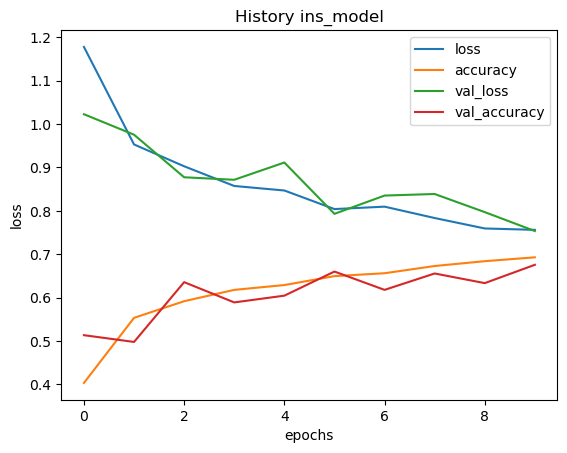

In [5]:
model_1 = Sequential([
  Conv2D(filters=10, 
         kernel_size=3,
         activation="relu", 
         input_shape=(224, 224, 3)), # first layer specifies input shape (height, width, colour channels)
  Conv2D(10, 3, activation="relu"),
  MaxPool2D(2),
  Conv2D(10, 3, activation="relu"),
  Conv2D(10, 3, activation="relu"),
  MaxPool2D(2),
  Flatten(),
  Dense(3, activation="softmax")
])

model_1.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

history_1 = train_time_and_efficiency(model_1, train_data, 10, val_data, test_data)

model_1.summary()

pd.DataFrame(history_1.history).plot(xlabel="epochs", ylabel="loss", title="History ins_model")

Epoch 1/10
57/57 [==============================] - 124s 2s/step - loss: 1.8854 - accuracy: 0.4378 - val_loss: 0.9519 - val_accuracy: 0.5822
Epoch 2/10
57/57 [==============================] - 122s 2s/step - loss: 0.9176 - accuracy: 0.5844 - val_loss: 0.8964 - val_accuracy: 0.6111
Epoch 3/10
57/57 [==============================] - 120s 2s/step - loss: 0.8860 - accuracy: 0.6139 - val_loss: 0.8981 - val_accuracy: 0.6067
Epoch 4/10
57/57 [==============================] - 122s 2s/step - loss: 0.8980 - accuracy: 0.6128 - val_loss: 0.8457 - val_accuracy: 0.6333
Epoch 5/10
57/57 [==============================] - 121s 2s/step - loss: 0.8200 - accuracy: 0.6428 - val_loss: 0.8110 - val_accuracy: 0.6556
Epoch 6/10
57/57 [==============================] - 122s 2s/step - loss: 0.7954 - accuracy: 0.6756 - val_loss: 0.8195 - val_accuracy: 0.6378
Epoch 7/10
57/57 [==============================] - 135s 2s/step - loss: 0.7846 - accuracy: 0.6650 - val_loss: 0.8100 - val_accuracy: 0.6533
Epoch 8/10
57

<Axes: title={'center': 'History ins_model'}, xlabel='epochs', ylabel='loss'>

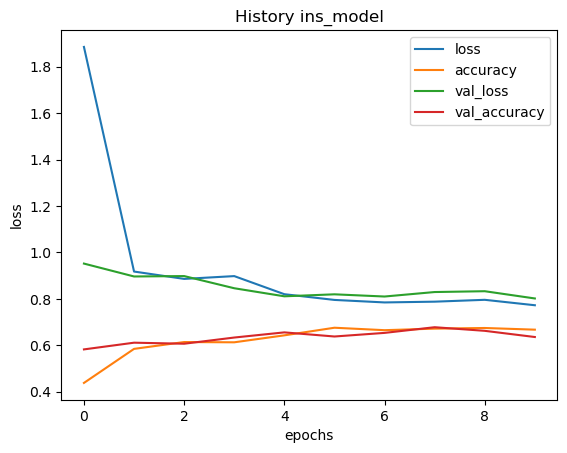

In [6]:
model_2 = Sequential([
  Conv2D(32, 3, activation="relu", input_shape=(224, 224, 3)), # first layer specifies input shape (height, width, colour channels)
  MaxPool2D(2),
  Conv2D(64, 3, activation="relu"),
  MaxPool2D(2),
  Flatten(),
  Dense(128, activation="relu"),
  Dense(3, activation="softmax")
])

model_2.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

history_2 = train_time_and_efficiency(model_2, train_data, 10, val_data, test_data)

model_2.summary()

pd.DataFrame(history_2.history).plot(xlabel="epochs", ylabel="loss", title="History ins_model")

Epoch 1/10
57/57 [==============================] - 406s 7s/step - loss: 1.2558 - accuracy: 0.3978 - val_loss: 1.0286 - val_accuracy: 0.4689 - lr: 0.0010
Epoch 2/10
57/57 [==============================] - 276s 5s/step - loss: 0.9314 - accuracy: 0.5467 - val_loss: 0.9143 - val_accuracy: 0.5911 - lr: 0.0010
Epoch 3/10
57/57 [==============================] - 253s 4s/step - loss: 0.9344 - accuracy: 0.5706 - val_loss: 0.9380 - val_accuracy: 0.5711 - lr: 0.0010
Epoch 4/10
57/57 [==============================] - 234s 4s/step - loss: 0.8703 - accuracy: 0.5989 - val_loss: 0.8554 - val_accuracy: 0.6578 - lr: 0.0010
Epoch 5/10
57/57 [==============================] - 254s 4s/step - loss: 0.8495 - accuracy: 0.6400 - val_loss: 0.8132 - val_accuracy: 0.6689 - lr: 0.0010
Epoch 6/10
57/57 [==============================] - 272s 5s/step - loss: 0.8026 - accuracy: 0.6500 - val_loss: 0.8088 - val_accuracy: 0.6644 - lr: 0.0010
Epoch 7/10
57/57 [==============================] - 309s 5s/step - loss: 0.7

<Axes: title={'center': 'History ins_model'}, xlabel='epochs', ylabel='loss'>

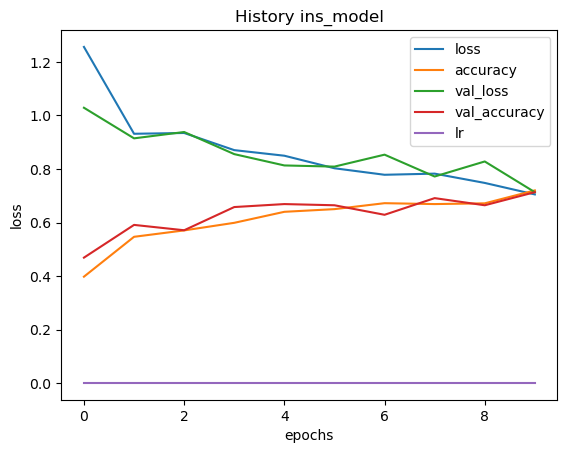

In [7]:
model_3 = Sequential([
  Conv2D(32, 3, activation="relu", input_shape=(224, 224, 3)), # first layer specifies input shape (height, width, colour channels)
  MaxPool2D(2),
  Conv2D(64, 3, activation="relu"),
  Conv2D(64, 3, activation="relu"),
  MaxPool2D(2),
  Conv2D(128, 3, activation="relu"),
  Conv2D(128, 3, activation="relu"),
  MaxPool2D(2),
  Flatten(),
  Dense(256, activation="relu"),
  Dense(3, activation="softmax")
])

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)

model_3.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

history_3 = train_time_and_efficiency(model_3, train_data, 10, val_data, test_data, lr_scheduler)

model_3.summary()

pd.DataFrame(history_3.history).plot(xlabel="epochs", ylabel="loss", title="History ins_model")

### EfficientNet model

Epoch 1/10
57/57 [==============================] - 1088s 17s/step - loss: 1.0882 - accuracy: 0.4378 - val_loss: 1.0676 - val_accuracy: 0.8711
Epoch 2/10
57/57 [==============================] - 1013s 18s/step - loss: 1.0468 - accuracy: 0.8844 - val_loss: 1.0286 - val_accuracy: 0.8644
Epoch 3/10
57/57 [==============================] - 1270s 22s/step - loss: 1.0068 - accuracy: 0.8950 - val_loss: 0.9911 - val_accuracy: 0.8778
Epoch 4/10
57/57 [==============================] - 1291s 23s/step - loss: 0.9692 - accuracy: 0.8983 - val_loss: 0.9575 - val_accuracy: 0.8556
Epoch 5/10
57/57 [==============================] - 1220s 21s/step - loss: 0.9346 - accuracy: 0.8850 - val_loss: 0.9193 - val_accuracy: 0.8778
Epoch 6/10
57/57 [==============================] - 1850s 33s/step - loss: 0.9013 - accuracy: 0.8917 - val_loss: 0.8895 - val_accuracy: 0.8822
Epoch 7/10
57/57 [==============================] - 937s 16s/step - loss: 0.8691 - accuracy: 0.8922 - val_loss: 0.8594 - val_accuracy: 0.8644


<Axes: title={'center': 'History ins_model'}, xlabel='epochs', ylabel='loss'>

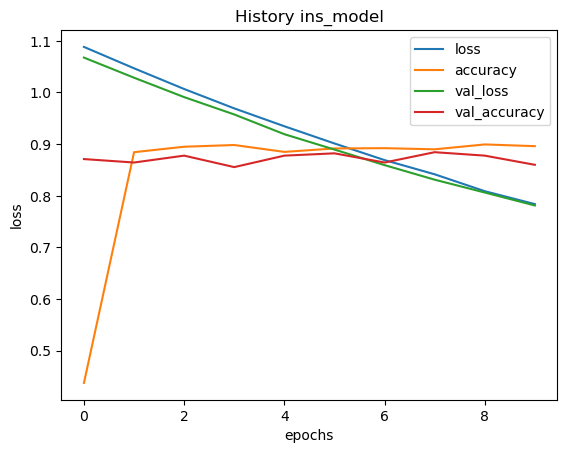

In [8]:
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b7/classification/1"

efficientnet_model = Sequential([
    hub.KerasLayer(efficientnet_url, trainable=False),
    Dense(3, activation='softmax')
])

efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer='adam',
                           metrics=['accuracy'])

history_efficientnet = train_time_and_efficiency(efficientnet_model, train_data, 10, val_data, test_data)

pd.DataFrame(history_efficientnet.history).plot(xlabel="epochs", ylabel="loss", title="History ins_model")